We will implement Decision Tree regressor as well as Gradient Boosting regressor using an ML pipeline 

In [146]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

## Import the data

We can look at some features of the data to help refine our models 

In [125]:
df_train = pd.read_excel('TrainDataset2025.xls')

# since 999 are Na values:
df_train.replace(999, np.nan, inplace=True)


X = df_train.drop(['ID','pCR (outcome)','RelapseFreeSurvival (outcome)'], axis=1)
y = df_train['RelapseFreeSurvival (outcome)']

print(df_train.shape)
print(X.describe())
df_train.head()

(400, 121)
              Age          ER         PgR        HER2  TrippleNegative  \
count  400.000000  400.000000  399.000000  399.000000       399.000000   
mean    51.804674    0.547500    0.406015    0.300752         0.333333   
std     10.948522    0.498362    0.491704    0.459161         0.471996   
min     23.000000    0.000000    0.000000    0.000000         0.000000   
25%     44.516769    0.000000    0.000000    0.000000         0.000000   
50%     51.019507    1.000000    0.000000    0.000000         0.000000   
75%     60.000000    1.000000    1.000000    1.000000         1.000000   
max     79.603012    1.000000    1.000000    1.000000         1.000000   

       ChemoGrade  Proliferation  HistologyType    LNStatus  TumourStage  ...  \
count  397.000000     398.000000     397.000000  399.000000   400.000000  ...   
mean     2.400504       1.575377       1.148615    0.533835     2.607500  ...   
std      0.500807       0.766487       0.356157    0.499480     0.897473  ...  

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1.0,144.0,41.0,0,0.0,0.0,1.0,3.0,3.0,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0.0,142.0,39.0,1,1.0,0.0,0.0,3.0,3.0,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1.0,135.0,31.0,0,0.0,0.0,1.0,2.0,1.0,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0.0,12.0,35.0,0,0.0,0.0,1.0,3.0,3.0,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0.0,109.0,61.0,1,0.0,0.0,0.0,2.0,1.0,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


## do a test train split


In [126]:
# ----- train / val split -----
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Now we can begin the ML pipelines

To start will do a pipeline without feature selection, just scaling and imputing, to get a baseline

In [127]:
preprocess = Pipeline(steps=[('scaler', StandardScaler()),
                       ('imputer',KNNImputer()) ]) 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeRegressor(random_state=42,max_depth=4,min_samples_leaf=2,))
])

# Gradient Boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingRegressor(random_state=42,n_estimators=200,learning_rate=0.05,max_depth=3,min_samples_leaf=2,subsample=0.8))
])

## Fit the models to get a baseline with no feature selection or hyperparameter tuning 

In [128]:
# Decsion Tree 
dt_pipeline.fit(X_train, y_train)
y_val_pred_dt = dt_pipeline.predict(X_val)
mae_dt = mean_absolute_error(y_val, y_val_pred_dt)
print(f"Baseline decision tree MAE: {mae_dt}")

# Gradient boosted
gb_pipeline.fit(X_train, y_train)
y_val_pred_gb = gb_pipeline.predict(X_val)
mae_gb = mean_absolute_error(y_val, y_val_pred_gb)
print(f"Baseline gradient boosting MAE: {mae_gb}")

Baseline decision tree MAE: 23.334891441131163
Baseline gradient boosting MAE: 22.71139336721702


## Now we have a baseline we can use a grid/randomised search to tune the hyperparameters 

First we can define the grids that will be searched for each model. we are using randomised search for gradient boost to decrease the runtime. 

In [129]:
dt_param_grid = {
    'model__max_depth': [2, 3, 4, 5, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

from scipy.stats import randint, uniform

gb_param_distributions = {
    'model__n_estimators': randint(100, 800),       # 100–800 trees
    'model__learning_rate': uniform(0.01, 0.15),    # 0.01–0.16
    'model__max_depth': randint(2, 6),              # depth 2–5
    'model__min_samples_split': randint(2, 10),     # 2–10
    'model__min_samples_leaf': randint(1, 10),      # 1–10
    'model__subsample': uniform(0.6, 0.4),          # 0.6–1.0
}

## perform the grid searches and fit the models again 

In [130]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

# Decision Tree search
dt_search = GridSearchCV(
    estimator=dt_pipeline,
    cv=5,
    param_grid = dt_param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
dt_search.fit(X_train, y_train)

print("Best decision tree MAE:", -dt_search.best_score_)

# Gradient Boosting search
gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=gb_param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

gb_search.fit(X_train, y_train)
print("Best gradient boosting MAE:", -gb_search.best_score_)


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best decision tree MAE: 21.947603054988495
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best gradient boosting MAE: 21.333229721707674


## Now we can start with feature selection 

We first need to separate the important features from the rest. 

In [131]:
all_features  = X.columns
important_features = ['ER','HER2','Gene']
rest_features  = list(set(all_features) - set(important_features))

##### for the pipeline, we will need two preprocessing pipelines as we want to leave the important features untouched

In [132]:
imp_preprocessing = Pipeline([('scaler',StandardScaler()),
                              ('imputer',KNNImputer())
                              ]) # we just scale and impute, leave these untouched otherwise

rest_preprocessing = Pipeline([ ('scaler',StandardScaler()),
                                ('imputer',KNNImputer()),
                                ('select', SelectKBest(score_func=f_regression, k=20)) # we select the 20 best features from the remaining ones 
                              ])

##### Now we can apply the each pipline to the correct columns using column transformer 

In [133]:
preprocess_split = ColumnTransformer(
    transformers=[
        ('important', imp_preprocessing, important_features),
        ('rest', rest_preprocessing, rest_features),
    ]
)

##### Now we can create the pipeline with the column transformers 

In [134]:
dt_pipe = Pipeline(
    [
        ('preprocess',preprocess_split),
        ('model',DecisionTreeRegressor(random_state=42,max_depth=4,min_samples_leaf=2,))
        
    ]
)

gb_pipe = Pipeline(
    [
        ('preprocess',preprocess_split),
        ('model',GradientBoostingRegressor(random_state=42,n_estimators=200,learning_rate=0.05,max_depth=3,min_samples_leaf=2,subsample=0.8,loss="huber",))
        
    ]
)

##### Now we can perform the hyperparameter tuning again for both the models 

In [135]:
# Decision Tree search
dt_search = GridSearchCV(
    estimator=dt_pipe,
    cv=5,
    param_grid = dt_param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
dt_search.fit(X_train, y_train)

print("Best decision tree MAE:", -dt_search.best_score_)

# Gradient Boosting search
gb_search = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=gb_param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

gb_search.fit(X_train, y_train)
print("Best gradient boosting MAE:", -gb_search.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best decision tree MAE: 21.96477451024969
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best gradient boosting MAE: 22.293681242787354


#### The results are worse, whats happening 

Decision trees and gradient boosting trees are strong with the raw features; like they have feature selection built in. Selecting the best 20 features will therefore not help, but hurt the models performance since we are only removing most of the features. So we will stick with using all the features

##### How can we actually improve our models performance? Since GBR has produces the lowest MAE thus far, we will be sticking with it from now on 

refine our grid search method to be optimised for the dataset. The dataset is small and noisy and the features values range wildly. We can use these characteristics to refine our randomised search. The current search regions are: 

gb_param_distributions = {

    'model__n_estimators': randint(100, 800),       
    'model__learning_rate': uniform(0.01, 0.15),  
    'model__max_depth': randint(2, 6),             
    'model__min_samples_split': randint(2, 10),   
    'model__min_samples_leaf': randint(1, 10),     
    'model__subsample': uniform(0.6, 0.4),  

}

With small datasets any ML model becomes more prone to overfitting. We can try and reduce this by using a smaller learning rate  0.01 - 0.15 -> 0.01,0.05. Since we have lowered the learning rate we will require more trees to converge so for n_estimators 100,800 -> 400,1000. 

We also want to avoid overfitting by using shallower trees therefore max_depth 2,6 -> 2,4. Also small leaves can have a similar effect so min_samples_leaf 1,10 -> 5,20. Similarly min_samples_split controlls how much the trees 'want' to split. Higher values mean a reduced chance of overfitting so 2,10 -> 5,20

The subsample needs to stay below 1 to ensure stochastic gradient boosting, again reducing overfitting tendancies 



In [141]:
gb_param_distributions = {
    'model__n_estimators': randint(400, 1000),       
    'model__learning_rate': uniform(0.01, 0.05),  
    'model__max_depth': randint(2, 4),             
    'model__min_samples_split': randint(5, 20),   
    'model__min_samples_leaf': randint(5, 20),     
    'model__subsample': uniform(0.6, 0.3),         
}

perform the random search again, we will use the unsplit data since feature selection only hurts performance as mentioned before. We also increase the number of iterations (candidates) to increase performance

In [142]:
# Gradient Boosting search
gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=gb_param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    n_iter=20
)



In [ ]:
gb_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              Pipeline(steps=[('scaler',
                                                               StandardScaler()),
                                                              ('imputer',
                                                               KNNImputer())])),
                                             ('model',
                                              GradientBoostingRegressor(learning_rate=0.05,
                                                                        min_samples_leaf=2,
                                                                        n_estimators=200,
                                                                        random_state=42,
                                                                        subsample=0.8))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': <scipy.stats._distn_infras...
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002DE792A04C0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002DE78FBD330>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002DE78E90970>},
                   scoring='neg_mean_absolute_error', verbose=1)

In [150]:
best_gb_pipe = gb_search.best_estimator_   
print("Best gradient boosting MAE:", -gb_search.best_score_)

Best gradient boosting MAE: 21.001281937646638


 Now we have a model that attains a resonable MAE with precautions in place to prevent overfitting, we can visualise the learning process, Important features and the data to try and get an understanding of what is most helpful in the predictions and how the data is structured 

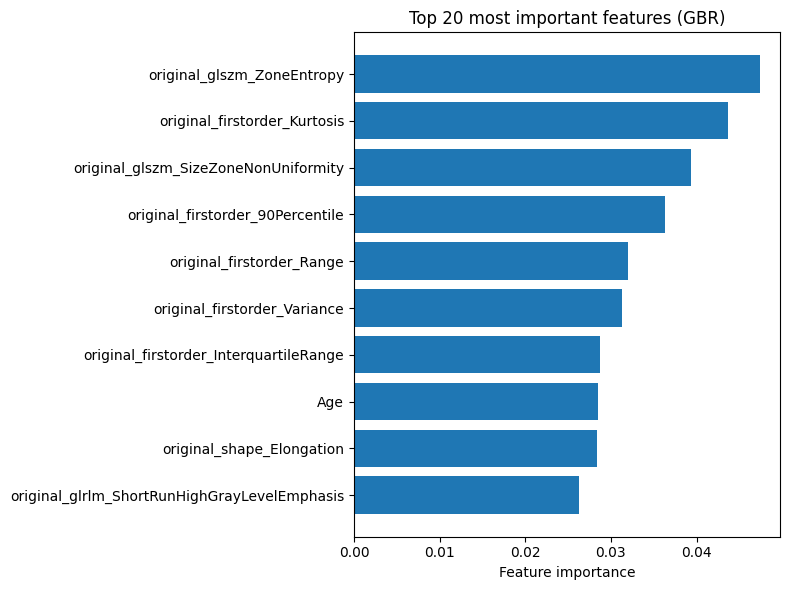

In [156]:
# plot of the feature importances that where found by the regressor 
gb_model = best_gb_pipe.named_steps['model']
importances = gb_model.feature_importances_
feature_names = X.columns.to_numpy()

# get 10 most important
idx = np.argsort(importances)[::-1][:10]
top_imp = importances[idx]
top_names = feature_names[idx]

plt.figure(figsize=(8,6))
plt.barh(range(len(top_imp)), top_imp[::-1])
plt.yticks(range(len(top_imp)), top_names[::-1])
plt.xlabel("Feature importance")
plt.title("Top 20 most important features (GBR)")
plt.tight_layout()



we can see the correlation between the important features 

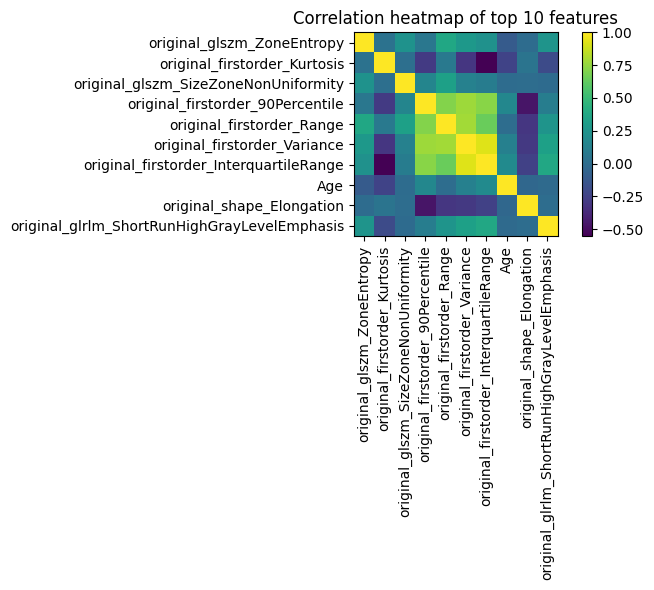

In [162]:
top_features = list(top_names) 
corr = X[top_features].corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr)
plt.colorbar(im, fraction=0.046,)
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.yticks(range(len(top_features)), top_features)
plt.title("Correlation heatmap of top 10 features")
plt.tight_layout()
plt.show()